## Machine Learning

<b>Bron</b> Notebook <a href="https://www.packtpub.com/big-data-and-business-intelligence/building-machine-learning-systems-python-second-edition" target="_blank">Building Machine Learning with Python (2e)</a>



# (tiny) application of machine learning

Let's get our hands dirty and take a look at our hypothetical web start-up, MLaaS, which sells the service of providing machine learning algorithms via HTTP. 

With increasing success of our company, the demand for better infrastructure increases to serve all incoming web requests successfully. We don't want to allocate too many resources as that would be too costly. On the other side, we will lose money, if we have not reserved enough resources to serve all incoming requests. 

Now, the question is, <b>when will we hit the limit of our current infrastructure, which we estimated to be at 100,000 requests per hour</b>. We would like to know in advance when we have to request additional servers in the cloud to serve all the incoming requests successfully without paying for unused ones.

Lets enter the data science pipeline.<br>
<b>?:</b> Which activities are included in the data scene pipeline?


## reading in the data 
File `web_traffic.tsv` contains web statistics for the last month and aggregated in the file. 

The data is stored as the number of hits per hour. Each line contains the hour consecutively and the number of web hits in that hour

**activity**<br>
Open the file `web_traffic.tsv` with a text-editor, and look at it briefly.

In [17]:
# web stats for the last month and aggregated them in web_traffic.tsv 
# Using SciPy's genfromtxt()
# Investigate: what is the type of the read data object?

import scipy as sp
path = 'datasets/'
data = sp.genfromtxt(path + "web_traffic.tsv", delimiter="\t")
# .tsv because it contains tab-separated values
#help(sp.genfromtxt)

In [20]:
# display some data
print (data[:10])

# display the dimensions of the data...
print(data.shape)

[[1.000e+00 2.272e+03]
 [2.000e+00       nan]
 [3.000e+00 1.386e+03]
 [4.000e+00 1.365e+03]
 [5.000e+00 1.488e+03]
 [6.000e+00 1.337e+03]
 [7.000e+00 1.883e+03]
 [8.000e+00 2.283e+03]
 [9.000e+00 1.335e+03]
 [1.000e+01 1.025e+03]]
(743, 2)


As you can see, we have 743 data points with two dimensions.
One caveat is still that we have some values in y that contain invalid values, <code>nan</code>.

In [ ]:
# OFF THE RECORD: using pandas to read data from web_traffic.tsv
import pandas as pd
df = pd.read_csv("datasets/web_traffic.tsv", sep='\t')
print(type(df))
df.head()

## preprocessing and cleaning the data

It is more convenient for SciPy to separate the dimensions into two vectors, each of size 743. The first vector, x, will contain the hours, and the other, y, will contain the Web hits in that particular hour. This splitting is done using the special index notation of SciPy, by which we can choose the columns individually.

There are many more ways in which data can be selected from a SciPy array. 
Check out http://www.scipy.org/Tentative_NumPy_Tutorial for more details on indexing, slicing, and iterating.

In [22]:
x = data[:,0]
y = data[:,1]

# how do I print the first 10 elements of x and y?

One caveat is still that we have some values in y that contain invalid values, <code>nan</code>. The question is what we can do with them? 

Let's check how many hours contain invalid data, by running the following code:

In [23]:
sp.sum(sp.isnan(y))

8

### what to do with the invalid data?
As you can see, we are missing only 8 out of 743 entries, so we can afford to remove them.

We can index a SciPy array with another array. <b>sp.isnan(y)</b> returns an array of Booleans indicating whether an entry is a number or not. Using <b>~</b>, we logically negate that array so that we choose only those elements from x and y where y contains valid numbers.

In [5]:
#sp.isnan(y)

In [24]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

# ?: how to check there are no invalid numbers 'nan' anymore?

### exploring data visually

To get the first impression of our data, let's plot the data in a scatter plot using matplotlib. Matplotlib contains the pyplot package.

<b>?:</b> Which (Matplotlib) style represents the pyplot package: MATLAB- or Object Oriented-style?

In [25]:
# display plots in Notebook cell
%matplotlib inline
import matplotlib.pyplot as plt

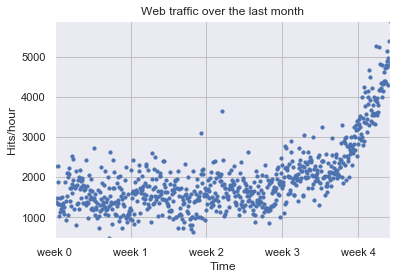

In [34]:
# plot the (x,y) points with dots of size 10
plt.scatter(x, y, s=10)

plt.title("Web traffic over the last month")
plt.xlabel("Time")
plt.ylabel("Hits/hour")
plt.xticks([w*7*24 for w in range(10)],
               ['week %i' % w for w in range(10)])
plt.autoscale(tight=True)
# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')

plt.show()

In the resulting chart, we can see that while in the first weeks the traffic stayed more or less the same, the last week shows a steep increase.

## Choosing the right model and learning algorithm
Now that we have a first impression of the data, we return to the initial question: <b>How long will our server handle the incoming web traffic? </b>

To answer this we have to do the following:

1. Find the real model behind the noisy data points.
2. Following this, use the model to extrapolate into the future to find the point in time where our infrastructure has to be extended.

### Build our first model

#### Before building our first model

When we talk about models, you can think of them as simplified theoretical approximations of complex reality. As such there is always some inferiority involved, also called the <b>approximation error</b>. 
It is said to be a discrepancy between approximated value and exact value.

This error will guide us in choosing the right model among the myriad of choices we have. And <b>this error will be calculated as the squared distance of the model's prediction <code>f(x)</code> to the real data <code>x</code></b>. For example, for a learned model function f, the error is calculated as follows:
        
        error = sum((f(x) - y)**2)

The vectors x and y contain the web stats data that we have extracted earlier. It is the beauty of SciPy's vectorized functions that we exploit here with f(x). 

The trained model is assumed to take a vector and return the results again as a vector of the same size so that we can use it to calculate the difference to y.

See more about approximation error: https://en.wikipedia.org/wiki/Approximation_error

In [35]:
def error(f, x, y):
    return sp.sum((f(x)-y)**2)

# note that a function is treated as a parameter in Python.

#### starting with a simple straight line

Let's assume for a second that the underlying model is a straight line. Then the challenge is how to best put that line into the chart so that it results in the smallest approximation error. 

straight line: <code>f(x) = a * x + b</code>, a and b to be determined

SciPy's <code>polyfit()</code> function does exactly that. Given data <code>x</code> and <code>y</code> and the desired order of the polynomial (a straight line has order 1), it finds the model function that minimizes the error function defined earlier.

The <code>polyfit()</code> function returns the parameters of the fitted model function, <code>fp1</code>. And by setting <code>full=True</code>, we also get additional background information on the fitting process. Of this, only residuals are of interest, which is exactly the error of the approximation:

In [36]:
fp1, residuals, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)

print("Model parameters: %s" % fp1) # slope, intercept
# -> Model parameters: [2.59619213  989.02487106]

print("residuals: ", residuals)
# -> [  3.17389767e+08]

Model parameters: [  2.59619213 989.02487106]
residuals:  [3.17389767e+08]


This means the best straight line fit is the following function:

            f(x) = 2.59619213 * x + 989.02487106

We then use <code>poly1d()</code> to create a model function from the model parameters:


In [37]:
f1 = sp.poly1d(fp1)
print(error(f1, x, y))    # 317389767.34

317389767.339778


We can now use <code>f1()</code> to plot our first trained model. 

In addition to the preceding plotting instructions, we simply add the following code. This will produce the following plot:

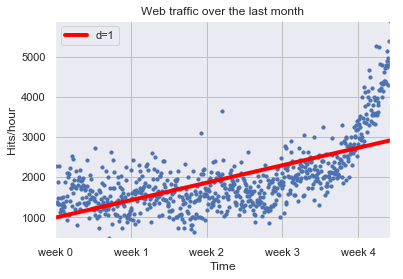

In [38]:
# plot the (x,y) points with dots of size 10
plt.scatter(x, y, s=10)

plt.title("Web traffic over the last month")
plt.xlabel("Time")
plt.ylabel("Hits/hour")
plt.xticks([w*7*24 for w in range(10)],
               ['week %i' % w for w in range(10)])
plt.autoscale(tight=True)
# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')

# draw the model function: straight line f1(x)
fx = sp.linspace(0,x[-1], 1000) # generate X-values for f1()
plt.plot(fx, f1(fx), linewidth=4, color='red')
plt.legend(["d=%i" % f1.order], loc="upper left")

# show the plot
plt.show()

It seems like the first 4 weeks are not that far off, although we clearly see that there is something wrong with our initial assumption that the underlying model is a straight line. And then, how good or how bad actually is the error of 317,389,767.34?

Although our first model clearly is not the one we would use, it serves a very important purpose in the workflow. We will use it as our baseline until we find a better one. Whatever model we come up with in the future, we will compare it against the current baseline.

#### towards some advanced stuff

Let's now fit a more complex model, a polynomial of degree 2, to see whether it better understands our data:

      f(x) = a * x**2  + b * x + c

In [39]:
fp2, res2, rank2, sv2, rcond2 = sp.polyfit(x, y, 2, full=True)
print(fp2)  # array([1.05322215e-02, -5.26545650e+00, 1.97476082e+03])

f2 = sp.poly1d(fp2)
print(error(f2, x, y))   # 179983507.878

[ 1.05322215e-02 -5.26545650e+00  1.97476082e+03]
179983507.8781792


The error is 179,983,507.878, which is almost half the error of the straight line model. This is good but unfortunately this comes with a price: We now have a more complex function, meaning that we have one parameter more to tune inside <code>polyfit()</code>. The fitted polynomial is as follows:

      f(x) = 0.0105322215 * x**2  - 5.26545650 * x + 1974.76082

You will get the following plot:

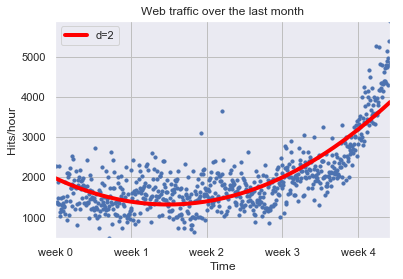

In [40]:
# plot the (x,y) points with dots of size 10
plt.scatter(x, y, s=10)

plt.title("Web traffic over the last month")
plt.xlabel("Time")
plt.ylabel("Hits/hour")
plt.xticks([w*7*24 for w in range(10)],
               ['week %i' % w for w in range(10)])
plt.autoscale(tight=True)
# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')

# draw the model function: f2(x)
fx = sp.linspace(0,x[-1], 1000) # generate X-values for plotting
plt.plot(fx, f2(fx), linewidth=4, color='red')
plt.legend(["d=%i" % f2.order], loc="upper left")

# show the plot
plt.show()

So, if more complexity gives better results, why not increase the complexity even more? Let's try it for degrees 3, 10, and 100.

In [41]:
# help function to draw the plot with a model function, 
#      and to save the plot in a file

import scipy as sp
import matplotlib.pyplot as plt

# all examples will have three classes in this file
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']

# plot input data...
def plot_models(x, y, models, fname, mx=None, ymax=None, xmin=None):

    plt.figure(num=None, figsize=(8, 6))
    plt.clf()
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000) # all data-points
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)

    # draw a slightly opaque, dashed grid
    plt.grid(True, linestyle='-', color='0.75')
    
    # save plot in an image file fname
    if fName is not None:  #2017_1214 added
        plt.savefig(fname)


/Users/pepo/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:578: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/pepo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/pepo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


Error d=3  :  139350144.03172523
Error d=10 :  121942326.36347426
Error d=100:  109452384.92468244


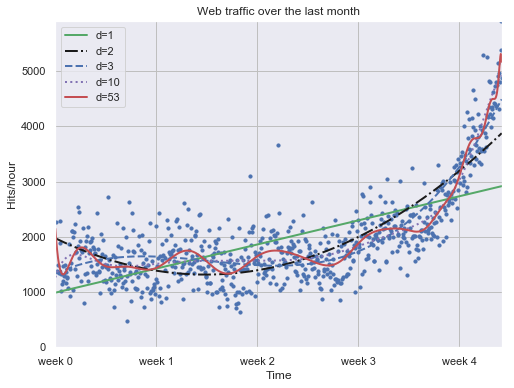

In [42]:
import os

# polynomial degree 3, 10 and 100:
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))
f100 = sp.poly1d(sp.polyfit(x, y, 100))

print("Error d=3  : ", error(f3, x, y))   # 139,350,144.031725
print("Error d=10 : ", error(f10, x, y))  # 121,942,326.363461
print("Error d=100: ", error(f100, x, y)) # 109,318,004.475556

# subfolder, must exists before running the code
# 2016_1218 Peter added
CHART_DIR = "figures" 

# plot the models f1 thru f100 in one figure
fName = os.path.join(CHART_DIR, "figure_all_models.png")
plot_models( x, y, [f1, f2, f3, f10, f100], fName )

# show in notebook
plt.show()

Interestingly, we do see <code>d=53</code> for the polynomial that had been fitted with 100 degrees. 

Instead, we see warnings on the console:

       Polyfit may be poorly conditioned

This means because of numerical errors, <code>polyfit</code> cannot determine a good fit with 100 degrees. Instead, it figured that 53 must be good enough.

### Conclusion

However, taking a closer look at the fitted curves, we start to wonder whether they also capture the true process that generated that data. Framed differently, <b>do our models correctly represent the underlying mass behavior of customers visiting our website</b>?

Looking at the polynomial of degree 10 and 53, we see wildly oscillating behavior. It seems that the <b>models are fitted too much to the data. So much that it is now capturing not only the underlying process but also the noise</b>. This is called <b>overfitting</b>.

At this point, we have the following choices:

    • Choosing one of the fitted polynomial models.
    • Switching to another more complex model class.
    • Thinking differently about the data and start again.
    
Out of the five fitted models, the first order model clearly is too simple, and the models of order 10 and 53 are clearly overfitting. 

Only the second and third order models seem to somehow match the data. However, if we extrapolate them at both borders, we see them going berserk.

<b>Switching to a more complex class seems also not to be the right way to go</b>. What arguments would back which class? At this point, we realize that we probably have not fully understood our data.

### Stepping back to go forward – another look at our data

So, we step back and take another look at the data. It seems that there is an inflection point between weeks 3 and 4. So let's separate the data and train two lines using week 3.5 as a separation point:

In [43]:
import math
# calculate the inflection point in hours (must be integer)
inflection = math.floor(3.5*7*24) 

xa = x[:inflection] # data before the inflection point
ya = y[:inflection]
xb = x[inflection:] # data after the inflection point
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection=%f" % (fa_error + fb_error))
# -> Error inflection=132950348.197616

Error inflection=132950348.197616


Error inflection=132950348.197616


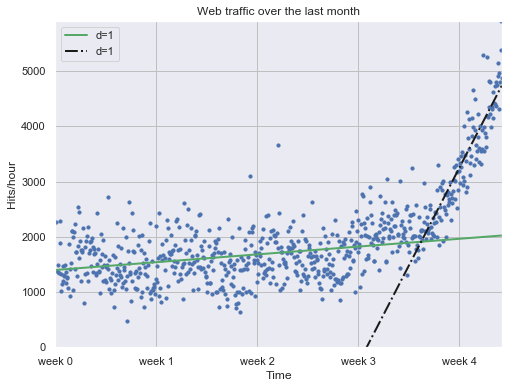

In [44]:
import math
# fit and plot a model using the knowledge about inflection point
# calculate the inflection point in hours
inflection = math.floor(3.5*7*24)

# data before the inflection point
xa = x[:inflection] 
ya = y[:inflection]

# data after the inflection point
xb = x[inflection:] 
yb = y[inflection:]

# calculate the new models fa and fb
fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)

print("Error inflection=%f" % (fa_error + fb_error))   
                        # Error inflection=132950348.197616

# plot the models
plot_models(x, y, [fa, fb], os.path.join(CHART_DIR, "figure_inflection.png"))

plt.show()

From the first line, we train with the data up to week 3, and in the second line we train with the remaining data.

Clearly, the combination of these two lines seems to be a much better fit to the data than anything we have modeled before. 

But still, the combined error is higher than the higher order polynomials. Can we trust the error at the end?

Asked differently, why do we trust the straight line fitted only at the last week of our data more than any of the more complex models? 

It is because we assume that it will capture future data better. If we plot the models into the future, we see how right we are (d=1 is again our initial straight line).

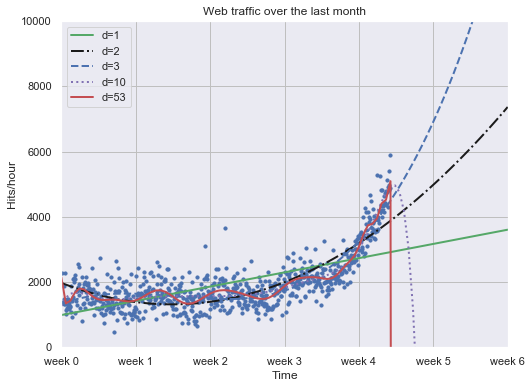

In [45]:
# extrapolating into the future
# linespace: calculation x in hours from week 0 until week 6
plot_models(
    x, y, [f1, f2, f3, f10, f100],
    os.path.join(CHART_DIR, "figure_06.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
                   ymax=10000, xmin=0 * 7 * 24)

plt.show()

The models of degree 10 and 53 don't seem to expect a bright future of our start-up. They tried so hard to model the given data correctly that they are clearly useless to extrapolate beyond. This is called <b>overfitting</b>.

On the other hand, the lower degree models seem not to be capable of capturing the data good enough. This is called <b>underfitting</b>.

So let's play fair to <b>models of degree 2 and above and try out how they behave if we fit them only to the data of the last week.</b>

After all, <b>we believe that the last week says more about the future than the data prior to it</b>. The result can be seen in the following psychedelic chart, which further shows how badly the problem of overfitting is.

Trained only on data after inflection point


/Users/pepo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/Users/pepo/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:578: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/pepo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/pepo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


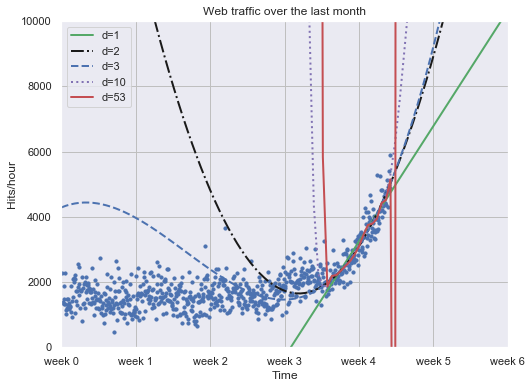

In [46]:
print("Trained only on data after inflection point")
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))

# plot of the models on data after inflection point...
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100],
    os.path.join(CHART_DIR, "figure_07.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

plt.show()

Still, judging from the errors of the models when trained only on the data from week 3.5 and later, we still should choose the most complex one (note that we also calculate the error only on the time after the inflection point):

In [47]:
print("\nErrors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

print("\nError inflection=%f" % (error(fa, xa, ya) + error(fb, xb, yb)))


Errors for only the time after inflection point
Error d=1: 22143941.107618
Error d=2: 19768846.989176
Error d=3: 19766452.361027
Error d=10: 18949296.608482
Error d=53: 18300741.551697

Error inflection=132950348.197616


### Training and testing

If we only had some data from the future that we could use to measure our models against, then we should be able to judge our model choice only on the resulting approximation error.

Although we cannot look into the future, we can and should simulate a similar effect by holding out a part of our data. Let's remove, for instance, a <b>certain percentage of the data and train on the remaining one</b>. 

Then we used the held-out data to calculate the error. As the model has been trained not knowing the held-out data, we should get a more realistic picture of how the model will behave in the future. 

fbt2(x)= 
         2
0.07819 x - 84.1 x + 2.431e+04

fbt2(x)-100,000= 
         2
0.07819 x - 84.1 x - 7.569e+04


Test errors for only the time after inflection point
Error d=1: 	7452613.136939
Error d=2: 	6831343.492614
Error d=3: 	6836879.130376
Error d=10: 	7065903.037681
Error d=53: 	7379721.933356


/Users/pepo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/Users/pepo/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:578: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/pepo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/pepo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RankWarning: Polyfit may be poorly conditioned


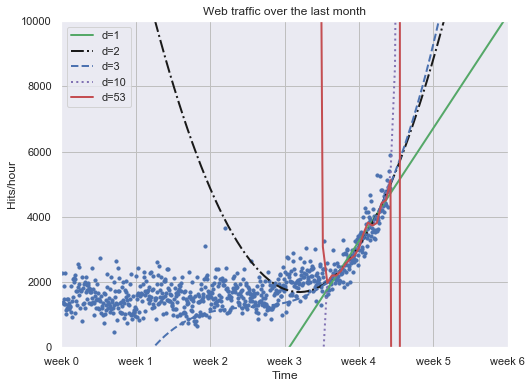

In [48]:
# separating training from testing data
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = sp.random.permutation(list(range(len(xb))))
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])

# models trained only on the time after inflection point
fbt1 = sp.poly1d(sp.polyfit(xb[train], yb[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))

# print the polynomial function parameters ...
print("fbt2(x)= \n%s"%fbt2)    
print("\nfbt2(x)-100,000= \n%s\n"%(fbt2-100000))

# generate model functions ...
fbt3 = sp.poly1d(sp.polyfit(xb[train], yb[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb[train], yb[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb[train], yb[train], 100))

# print the approximation errors ...
print("\nTest errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: \t%f" % (f.order, error(f, xb[test], yb[test])))

# plot the models ...
plot_models(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],
    os.path.join(CHART_DIR, "figure_08.png"),
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

plt.show()

It seems that we finally have a <em>clear</em> winner (<em>see Note</em>): The model with degree 2 has the lowest test error, which is the error when measured using data that the model did not see during training. And this gives us hope that we won't get bad surprises when future data arrives.

<em>Note</em>: the training set are random numbers! It is not always clear that d=2 had lowest error. Running after several samples, d=2 had <b>mostly</b> the lowest error.

## Answering our initial question

Finally we have arrived at a model which we think represents the underlying process best; it is now a simple task of finding out when our infrastructure will reach 100,000 
requests per hour. We have to calculate when our model function reaches the value 100,000.

Having a polynomial of degree 2, we could simply compute the inverse of the function and calculate its value at 100,000. Of course, we would like to have an approach that is applicable to any model function easily.

This can be done by subtracting 100,000 from the polynomial, which results in another polynomial, and finding its root. 

SciPy's <code>optimize</code> module has the function <code>fsolve</code> that achieves this, when providing an initial starting position with parameter <code>x0</code>. 

As every entry in our input data file corresponds to one hour, and we have 743 of them, we set the starting position to some value after that. Let <code>fbt2</code> be the winning polynomial of degree 2.

In [49]:
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))

# pint the polynomial model function
print("fbt2(x)= \n%s\n" % fbt2)
print("fbt2(x)-100,000= \n%s\n\n" % (fbt2-100000))

# calculate the week of the 100000 hits/hour ...
from scipy.optimize import fsolve
reached_max = fsolve(fbt2-100000, x0=800)/(7*24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

fbt2(x)= 
         2
0.07819 x - 84.1 x + 2.431e+04

fbt2(x)-100,000= 
         2
0.07819 x - 84.1 x - 7.569e+04


100,000 hits/hour expected at week 9.875373


... so our model tells us that, given the current user behavior and traction of our start-up, it will take another month until we have reached our capacity threshold.

Of course, there is a certain uncertainty involved with our prediction. To get a real picture of it, one could draw in more sophisticated statistics to find out about the variance we have to expect when looking farther and farther into the future.

And then there are the user and underlying user behavior dynamics that we cannot model accurately. However, at this point, we are fine with the current predictions. After all, we can prepare all time-consuming actions now. If we then monitor our web traffic closely, we will see in time when we have to allocate new resources.

# Summary

Congratulations! You just learned two important things, of which the most important one is that as a typical machine learning operator, <b>you will spend most of your time in understanding and refining the data </b>—exactly what we just did in our first tiny machine learning example.

And we hope that this example helped you to  <b>start switching your mental focus from algorithms to data</b>. Then you learned how important it is to have the correct experiment setup and that it is vital to not mix up training and testing.

Admittedly, the use of polynomial fitting is not the coolest thing in the machine learning world. We have chosen it to not distract you by the coolness of some shiny algorithm when we conveyed the two most important messages we just summarized earlier.
